In [1]:
import logging
import time
from platform import python_version
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers


In [2]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [4]:
train = pd.read_csv('atis_intents.csv')[:4000]
test = pd.read_csv('atis_intents.csv')[4000:]
print(train.shape,test.shape)

(4000, 2) (978, 2)


In [5]:
train.head()

,intent,text
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...


In [6]:
test.head()

,intent,text
4000,atis_flight,list all flights from seattle on continental ...
4001,atis_flight,i'd like the earliest flight information from...
4002,atis_flight,what is the cheapest flight from pittsburgh t...
4003,atis_flight,show me the flights from atlanta to washingto...
4004,atis_flight,flights from milwaukee to orlando one way


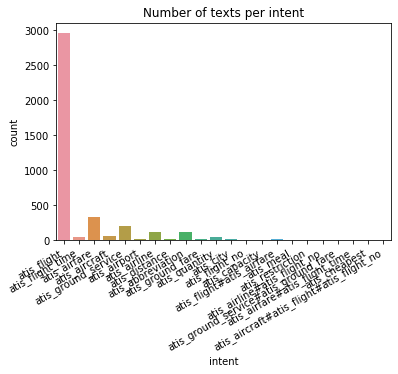

In [7]:
chart = sns.countplot(train.intent)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [8]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-06-15 10:52:43--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.10.16
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.10.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  20.4MB/s    in 17s     

2020-06-15 10:53:00 (22.9 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [9]:
columns_titles = ["text","intent"]
train=train.reindex(columns=columns_titles)
test=test.reindex(columns=columns_titles)

In [10]:
test.head()

,text,intent
4000,list all flights from seattle on continental ...,atis_flight
4001,i'd like the earliest flight information from...,atis_flight
4002,what is the cheapest flight from pittsburgh t...,atis_flight
4003,show me the flights from atlanta to washingto...,atis_flight
4004,flights from milwaukee to orlando one way,atis_flight


In [11]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [12]:
os.makedirs("model", exist_ok=True)

In [13]:
!mv uncased_L-12_H-768_A-12/ model

In [14]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [15]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [16]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [17]:
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [18]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [19]:
train.intent.unique().tolist()

['atis_flight',
 'atis_flight_time',
 'atis_airfare',
 'atis_aircraft',
 'atis_ground_service',
 'atis_airport',
 'atis_airline',
 'atis_distance',
 'atis_abbreviation',
 'atis_ground_fare',
 'atis_quantity',
 'atis_city',
 'atis_flight_no',
 'atis_capacity',
 'atis_flight#atis_airfare',
 'atis_meal',
 'atis_restriction',
 'atis_airline#atis_flight_no',
 'atis_ground_service#atis_ground_fare',
 'atis_airfare#atis_flight_time',
 'atis_cheapest',
 'atis_aircraft#atis_flight#atis_flight_no']

In [20]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [21]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

4000it [00:02, 1640.22it/s]
978it [00:00, 1800.96it/s]

max seq_len 52


In [22]:
data.train_x.shape

(4000, 52)

In [23]:
data.train_x[0]

array([  101,  1045,  2215,  2000,  4875,  2013,  3731,  2012,  6640,
        2620,  2572,  1998,  7180,  1999,  7573,  2012, 11118,  2692,
        1999,  1996,  2851,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [24]:
data.train_y[0]

0

In [25]:
data.max_seq_len

52

In [26]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 52, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f844b7820d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 52)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 52, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                16918 

In [28]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
histo = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  verbose = 1,
  batch_size=16,
  shuffle=True,
  epochs=8
)

Epoch 1/8
225/225 [==============================] - 1720s 8s/step - loss: 2.4461 - acc: 0.7303 - val_loss: 2.4613 - val_acc: 0.7050
Epoch 2/8
225/225 [==============================] - 1738s 8s/step - loss: 2.4229 - acc: 0.7436 - val_loss: 2.4612 - val_acc: 0.7050
Epoch 3/8


KeyboardInterrupt: 

___